# MNIST Standard Biological Images: Logistic Regression

In [277]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss
import time
import re

In [278]:
def flatten_X_data(contained_array, x_data):
    x_shape = x_data.shape
    end_of_range = len(x_shape)
    #print("end_of_range:", end_of_range)

    dim = ""
    if end_of_range == 4:
        if x_shape[3] == 3:
            dim = "RGB images:"
        else:
            dim = "3D images: "
        dim = dim + str(x_shape[1]) + "x" + str(x_shape[2]) + "x" + str(x_shape[3])
    elif end_of_range == 3:
        dim = "2D images: " + str(x_shape[1]) + "x" + str(x_shape[2])
    if (dim != ""):
        print(f"  {contained_array}: {x_shape[0]} {dim}")
    
    if (end_of_range > 2):
        # Handle 2D, 3D, ... nD image dimensions
        flat_sz = 1
        for ix in range(1, end_of_range):
            flat_sz = flat_sz * x_shape[ix]
        #print("flat_sz:", flat_sz)
        x_data = x_data.reshape(-1, flat_sz)
    else:
        # Convert label dimensions to 1D
        x_data = np.ravel(x_data, order='C')
    return(x_data)

In [279]:
def load_and_flatten(fn):
    blood_npz = np.load(fn, allow_pickle=True)
    #print(fn, "arrays:", blood_npz.files)

    data_arr = {}
    label_arr = {}
    substr = "labels"
    yx = 0
    for contained_array in blood_npz.files:
        #print(f"BEFORE: {contained_array}: {blood_npz[contained_array].shape}")
        arr = flatten_X_data(contained_array, blood_npz[contained_array])
        #print("arr.shape:", arr.shape) 
        #print(f"{substr}:{contained_array}")
        match = re.search(substr, contained_array)
        if (match):
            label_arr[contained_array] = arr
            #print(f"{contained_array} (flattened): {label_arr[contained_array].shape}")
        else:
            data_arr[contained_array] = arr
            #print(f"{contained_array} (flattened): {data_arr[contained_array].shape}")
    return data_arr, label_arr

In [280]:
def normalize_X_data(x_data):

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scale the dataset
    x_scaled = scaler.fit_transform(x_data)

    return(x_scaled)

In [281]:
def createAndTrainLRClassifier(X_train, y_train):
    # Train the logistic regression classifier
    LRModel = LogisticRegression(max_iter=5000)
    start = time.time()
    LRModel.fit(X_train, y_train)
    LR_fit_elapsed = time.time() - start
    print(f"  LR Fit time:     {round(LR_fit_elapsed, 2)}")
    return LRModel

In [282]:
def generate_predictions(LRModel, X_test):
    # Using the trained model, generate predictions from the test data
    start = time.time()
    y_pred_LR = LRModel.predict(X_test)
    LR_pred_elapsed = time.time() - start
    print(f"  LR Predict time: {round(LR_pred_elapsed, 2)}")
    return y_pred_LR

In [283]:
def display_confusion_matrix(y_tst, y_prd, ttl, sz=5, lbl=None):
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_tst, y_prd)

    # Plot confusion matrix with labels
    fig, ax = plt.subplots(figsize=(sz,sz))
    
    if (lbl != None):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)

        # Set labels and title
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        # Set tick labels
        ax.set_xticks(np.arange(len(lbl)))
        ax.set_yticks(np.arange(len(lbl)))
        ax.set_xticklabels(lbl)
        ax.set_yticklabels(lbl)

        # Rotate x-tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add values to cells (optional)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Customize plot
    plt.title(ttl)
    plt.show()

    #cm = confusion_matrix(np.arange(25), np.arange(25))
    #cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
    #fig, ax = plt.subplots(figsize=(10,10))
    #cmp.plot(ax=ax)

In [284]:
def accuracy_and_confusion(title, LR_mdl, X_test, y_test, y_pred_LR):
    y_pred_proba_LR = LR_mdl.predict_proba(X_test) # Needed for Log Loss

    ## Calculate the Accuracy Score, comparing predictions against test data
    LRacc = accuracy_score(y_test, y_pred_LR)
    print(f"Accuracy: {round(LRacc * 100, 2)}%")

    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba_LR, normalize=True)
    print("Log Loss:", loss)

    # Generate and display the confusion matrix
    #cm1 = confusion_matrix(y_test, y_pred_LR)
    #cmd = ConfusionMatrixDisplay(cm1)
    #cmd.title = "Test"
    #cmd.plot()
    size_plot = 5
    if (X_test.shape[0] > 3500):
        size_plot = 8
    display_confusion_matrix(y_test, y_pred_LR, title, size_plot)

In [285]:
def LR(fn):
    title = fn + ": Logistic Regression"
    print("\n-------------------------------------------------------")
    print(f"{title}")
    features, labels = load_and_flatten(fn)

    for key in features:
        features[key] = normalize_X_data(features[key])

    # Confirm data/label order is maintained
    feature_keys = list(features.keys())
    label_keys = list(labels.keys())
    #print("feature keys: ", feature_keys)
    #print("label keys:", label_keys)

    X_train = features[feature_keys[0]]
    y_train = labels[label_keys[0]]
    X_val = features[feature_keys[1]]
    y_val = labels[label_keys[1]]
    X_test = features[feature_keys[2]]
    y_test = labels[label_keys[2]]

    LR_mdl = createAndTrainLRClassifier(X_train, y_train)

    y_pred_LR = generate_predictions(LR_mdl, X_test)

    accuracy_and_confusion(title, LR_mdl, X_test, y_test, y_pred_LR)


-------------------------------------------------------
bloodmnist.npz: Logistic Regression
  train_images: 11959 RGB images:28x28x3
  val_images: 1712 RGB images:28x28x3
  test_images: 3421 RGB images:28x28x3
  LR Fit time:     24.83
  LR Predict time: 0.01
Accuracy: 77.99%
Log Loss: 0.6611909671726888


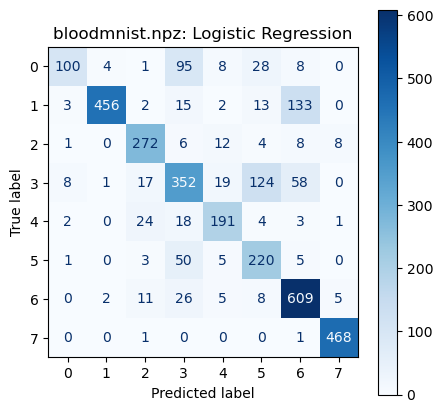


-------------------------------------------------------
breastmnist.npz: Logistic Regression
  train_images: 546 2D images: 28x28
  val_images: 78 2D images: 28x28
  test_images: 156 2D images: 28x28
  LR Fit time:     0.01
  LR Predict time: 0.0
Accuracy: 77.56%
Log Loss: 0.5172515280003986


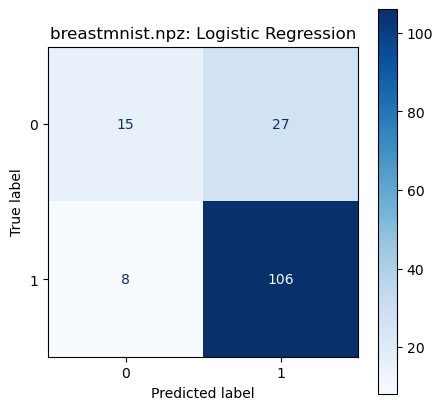


-------------------------------------------------------
dermamnist.npz: Logistic Regression
  train_images: 7007 RGB images:28x28x3
  val_images: 1003 RGB images:28x28x3
  test_images: 2005 RGB images:28x28x3
  LR Fit time:     13.37
  LR Predict time: 0.0
Accuracy: 70.37%
Log Loss: 0.9126743278895993


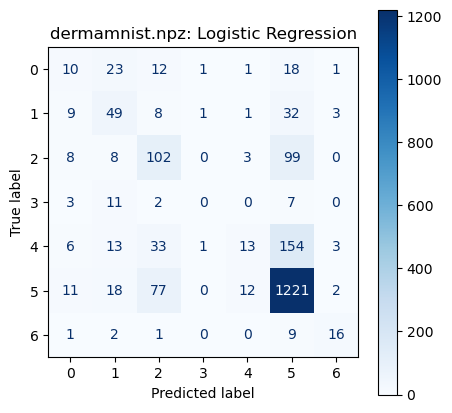


-------------------------------------------------------
octmnist.npz: Logistic Regression
  train_images: 97477 2D images: 28x28
  val_images: 10832 2D images: 28x28
  test_images: 1000 2D images: 28x28
  LR Fit time:     29.03
  LR Predict time: 0.0
Accuracy: 36.8%
Log Loss: 1.7935424166940517


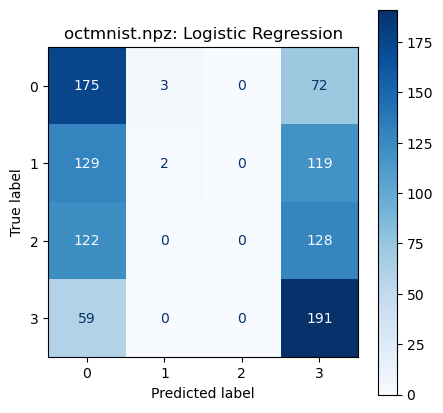


-------------------------------------------------------
organsmnist.npz: Logistic Regression
  train_images: 13932 2D images: 28x28
  val_images: 2452 2D images: 28x28
  test_images: 8827 2D images: 28x28
  LR Fit time:     5.76
  LR Predict time: 0.01
Accuracy: 40.81%
Log Loss: 1.89716028311433


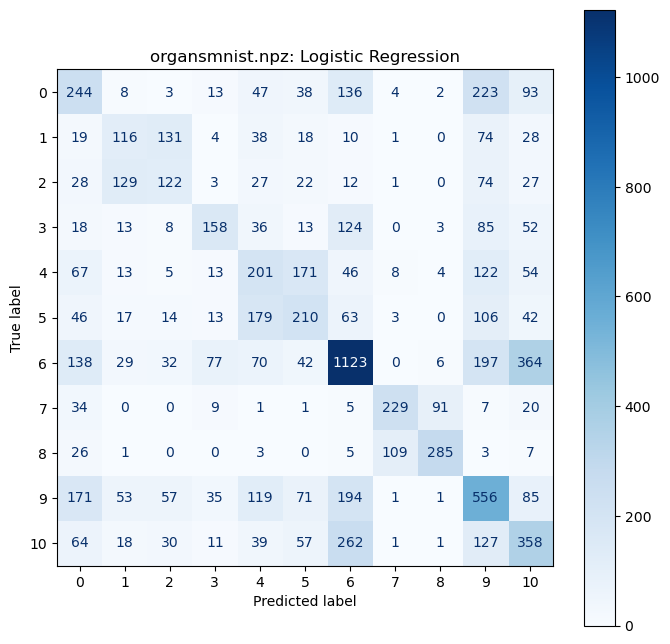


-------------------------------------------------------
nodulemnist3d.npz: Logistic Regression
  train_images: 1158 3D images: 28x28x28
  val_images: 165 3D images: 28x28x28
  test_images: 310 3D images: 28x28x28
  LR Fit time:     2.11
  LR Predict time: 0.01
Accuracy: 81.29%
Log Loss: 0.5574360634704795


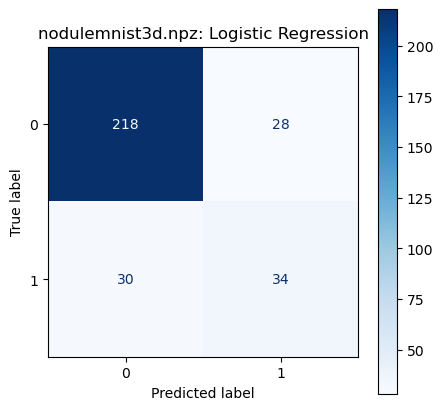


-------------------------------------------------------
organmnist3d.npz: Logistic Regression
  train_images: 971 3D images: 28x28x28
  val_images: 161 3D images: 28x28x28
  test_images: 610 3D images: 28x28x28
  LR Fit time:     7.19
  LR Predict time: 0.01
Accuracy: 76.39%
Log Loss: 0.8877229627957746


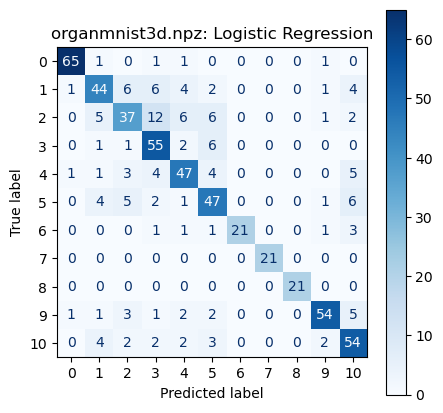


-------------------------------------------------------
retinamnist_128.npz: Logistic Regression
  train_images: 1080 RGB images:128x128x3
  val_images: 120 RGB images:128x128x3
  test_images: 400 RGB images:128x128x3
  LR Fit time:     37.57
  LR Predict time: 0.02
Accuracy: 38.25%
Log Loss: 3.099791673446137


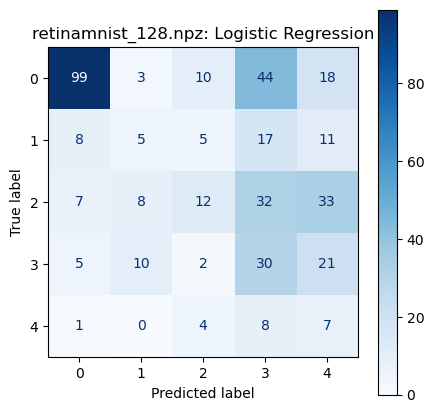

In [286]:
# NOTE: 'chestmnist.npz', # image, label size length mismatch
files = ['bloodmnist.npz', 'breastmnist.npz', 'dermamnist.npz', 'octmnist.npz', 'organsmnist.npz', \
         'nodulemnist3d.npz', 'organmnist3d.npz', 'retinamnist_128.npz']
#files = ['bloodmnist.npz', 'breastmnist.npz']

for file_name in files:
    LR(file_name)